# Interpretable ML

A significant barrier to ML's adoption in many fields is the lack of interpretability of black box models. In this project, I use several techniques to gain insights into various models.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Partial Dependence Plots

Partial Dependence Plots are a means of understanding the relationship between a variables and the response.

The PDPs show the relationship between the target variable and all the independent variables one by one, by 'integrating' out each of the variables'.

Load bike rentals data from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset and perform a partial dependence plot betwen target variables and the weather related variables, humidity, windspeed and temperature. This is a regression dataset which shows the bikes rented out on a particular day depending on certain variables. The target variable is the count of rentals.

In [3]:
bike_day_df_raws = pd.read_csv("/home/niki/Code/Notebooks/data/bike.csv")
bike_day_df_raws.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [9]:
bike_day_df_raws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


Use a gradient boosting regressor with 100 estimators of depth 1 and use 100 points as a test set to evaluate on

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence
data = bike_day_df_raws[["temp", "hum", "windspeed", "cnt"]]

In [11]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :3], data.iloc[:, 3], test_size=100)

# Fit model
model = GradientBoostingRegressor(max_depth=1, n_estimators=100)
model.fit(X_train, y_train)

# Evaluate model
score = model.score(X_test, y_test)
score

0.590936233821741

In [12]:
X_train.columns

Index(['temp', 'hum', 'windspeed'], dtype='object')

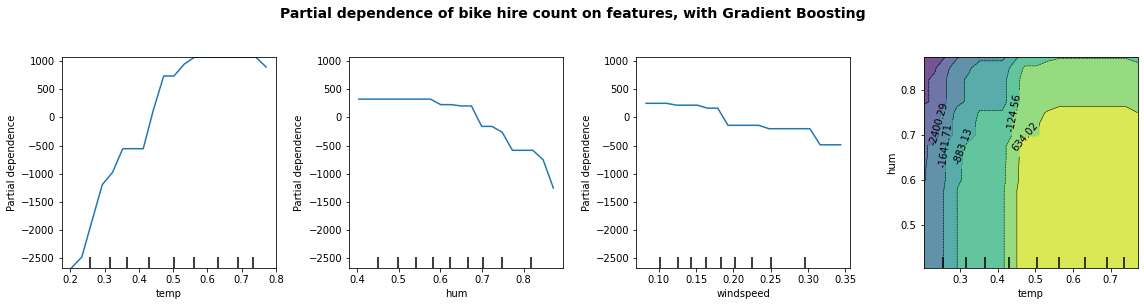

In [13]:
# Partial dependence plot
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

_, ax = plt.subplots(ncols=4, figsize=(16,4))

features = ["temp", "hum", "windspeed", ("temp", "hum")]
pdp = PartialDependenceDisplay.from_estimator(model,
                                              X_train,
                                              features=features,
                                              kind="average",
                                              grid_resolution=20,
                                              ax=ax)


display(wspace=0.1, hspace=0.1)
plt.suptitle("Partial dependence of bike hire count on features, with Gradient Boosting", y=1.05, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# LIME

Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models. Surrogate models are trained to approximate the predictions of the underlying black box model. Instead of training a global surrogate model, LIME focuses on training local surrogate models to explain individual predictions.

The LIME method helps to interpret how an image classifier works. To train local surrogate models, we need to:

* Select image of interest
* Perturb the dataset and get the black box predictions for these new points.
* Weight the new samples according to their proximity to the instance of interest.
* Train a weighted, interpretable model (LASSO) on the dataset with the variations.
* Explain the prediction by interpreting the local model.

In [14]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import skimage

# Using a pretrained Inception model

Load a pretrained Inception model

In [15]:
inet_model = inc_net.InceptionV3()

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

Load in this default image and get the top 5 predictions from the Inception model

('n01484850', 'great_white_shark', 0.7154656)
('n01494475', 'hammerhead', 0.031451795)
('n02071294', 'killer_whale', 0.029099643)
('n01491361', 'tiger_shark', 0.02496526)
('n02077923', 'sea_lion', 0.021726549)


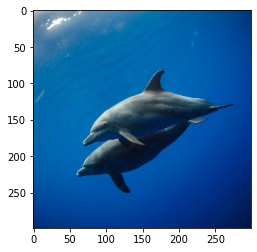

In [24]:
images = transform_img_fn(["/home/niki/Code/Notebooks/data/dolphins.jpg"]) 

# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

In [17]:
import os,sys
import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [18]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

100%|██████████| 1000/1000 [01:36<00:00, 10.38it/s]


CPU times: user 7min 38s, sys: 11.6 s, total: 7min 49s
Wall time: 1min 37s


Visualise the explanation for the top class (Black Bear). We can see the top 5 superpixels that are most positive towards the class with the rest of the image present (hide_rest=False).

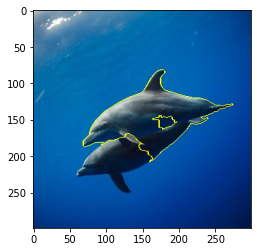

In [19]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

We can also see the 'pros and cons' (pros in green, cons in red)

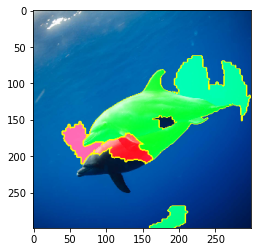

In [20]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Select the super pixels that have weight at least 0.1.

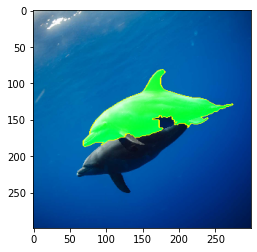

In [21]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
# import skimage
# array_double = np.array(images[0], dtype=np.double) # Need to convert array to dtype "double"
# superpixels = skimage.segmentation.quickshift(array_double, kernel_size=4,max_dist=200, ratio=0.2)
# num_superpixels = np.unique(superpixels).shape[0]
# num_superpixels

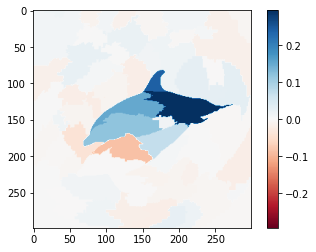

In [22]:
ind = explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(heatmap, cmap='RdBu', vmin= -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

Pick the groenendaal class now. What super pixels are being selected to output this particular classification with LIME?

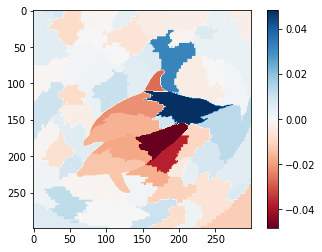

In [23]:
groenendaal_superpixels = explanation.top_labels[1]

dict_heatmap = dict(explanation.local_exp[groenendaal_superpixels])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(heatmap, cmap='RdBu', vmin = -heatmap.max(), vmax=heatmap.max())
plt.colorbar()

With another image:

('n02444819', 'otter', 0.90063584)
('n02137549', 'mongoose', 0.010732522)
('n02077923', 'sea_lion', 0.0050774575)
('n02441942', 'weasel', 0.0028585442)
('n02363005', 'beaver', 0.0026682627)


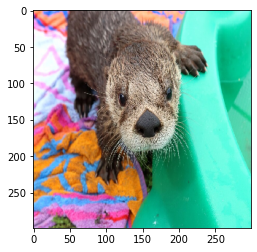

In [26]:
# Load in the image and see the top predictions
images_2 = transform_img_fn(["/home/niki/Code/Notebooks/data/otter.jpeg"]) 

# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images_2[0] / 2 + 0.5)
preds = inet_model.predict(images_2)
for x in decode_predictions(preds)[0]:
    print(x)

In [27]:
# Generate explanation
explanation = explainer.explain_instance(images_2[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


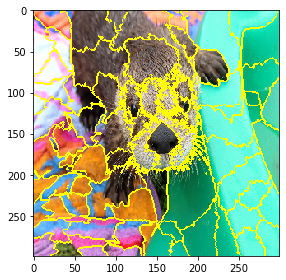

In [28]:
# Segment image into superpixels
array_double = np.array(images_2[0], dtype=np.double)
superpixels = skimage.segmentation.quickshift(array_double, kernel_size=4,max_dist=200, ratio=0.2)
skimage.io.imshow(skimage.segmentation.mark_boundaries(images_2[0]/2+0.5, superpixels))

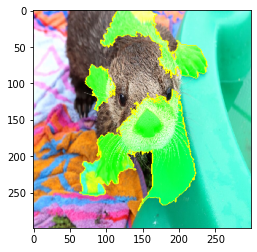

In [29]:
# Show top 10 superpixels
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

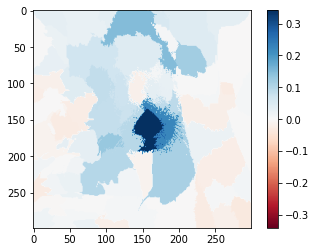

In [30]:
# Show heatmap of superpixels
ind = explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(heatmap, cmap='RdBu', vmin= -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# SHAP

SHAP is another game theoritic measure used for model interpretability. I will use the cervical cancer data from the UCI repository: https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29.

The Shapley value of a feature represents its average marginal contribution to the prediction, given other features in a coalition. What you do is work out every possible combination of features. Then, for each combination, you hold all features apart from one of them constant, and then you randomly sample x times to generate x instances of that combination where the one feature is allowed to vary. Then you calculate the average marginal contribution of that feature given the particular coalition. Then you repeat for every possible coalition and average those marginal average contributions, giving you the overall marginal average contribution. Then you repeat for every feature. It's very computationally expensive!

SHAP (Shapley Additive Explanations) is the Python package for using Shapley values to understand black box models. It connects Shapley values with LIME.

In [31]:
cancer = pd.read_csv("/home/niki/Code/Notebooks/data/risk_factors_cervical_cancer.csv", na_values='?') 

cancer.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


There are a few NAs in the data.

In [32]:
cancer_data = cancer[['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies',
 'Smokes', 'Smokes (years)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)',
 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis',
 'STDs: Time since last diagnosis', 'Biopsy']]
cancer_data.isna().sum()

Age                                   0
Number of sexual partners            26
First sexual intercourse              7
Num of pregnancies                   56
Smokes                               13
Smokes (years)                       13
Hormonal Contraceptives             108
Hormonal Contraceptives (years)     108
IUD                                 117
IUD (years)                         117
STDs                                105
STDs (number)                       105
STDs: Number of diagnosis             0
STDs: Time since first diagnosis    787
STDs: Time since last diagnosis     787
Biopsy                                0
dtype: int64

Let's use a crude imputation method which is to fill in the NAs with their mode

In [33]:
cancer_data_imputed = cancer_data.fillna(cancer_data.mode().iloc[0])
cancer_data_imputed.isna().sum()

Age                                 0
Number of sexual partners           0
First sexual intercourse            0
Num of pregnancies                  0
Smokes                              0
Smokes (years)                      0
Hormonal Contraceptives             0
Hormonal Contraceptives (years)     0
IUD                                 0
IUD (years)                         0
STDs                                0
STDs (number)                       0
STDs: Number of diagnosis           0
STDs: Time since first diagnosis    0
STDs: Time since last diagnosis     0
Biopsy                              0
dtype: int64

Now split the data into a train and test set and use a random forest classifier on the cancer dataset

In [35]:
from sklearn.ensemble import RandomForestClassifier
cancer_arr = cancer_data_imputed.to_numpy()

In [ ]:
# Manual train test split
# X = cancer_arr[:, :15]
# mask = np.random.rand(len(X)) < 0.8
# X_train = X[mask]
# X_test = X[~mask]

# y = cancer_arr[:, 15]
# mask = np.random.rand(len(y)) < 0.8
# y_train = y[mask]
# y_test = y[~mask]

In [36]:
# Automatic train test split
X = cancer_arr[:, :15]
y = cancer_arr[:, 15]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(f"Score: {clf.score(X_test, y_test)}")

Score: 0.9534883720930233


Let's look at the RF's mean decrease in impurity: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#tree-s-feature-importance-from-mean-decrease-in-impurity-mdi. This is calculated on the training data :(, and measures how well a split is able to segregate classes of data for a feature.

Now let's use the Shapley value. use the package shap: `pip install shap`. The documentation can be found here https://github.com/slundberg/shap.

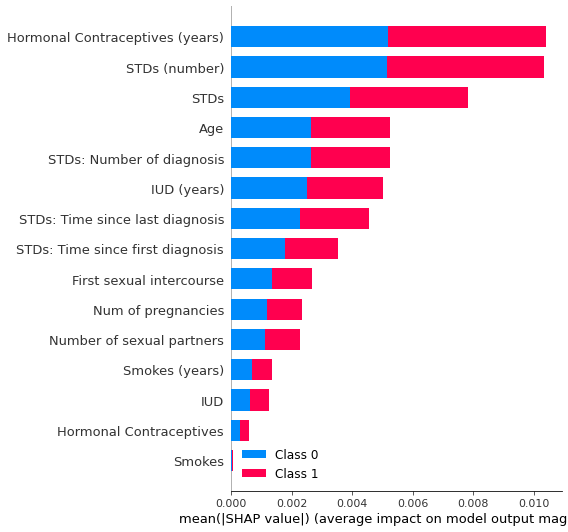

In [38]:
import shap
explainer = shap.TreeExplainer(clf)
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = list(cancer_data_imputed)[:-1]
shap_values = explainer.shap_values(X_train_df)
shap.summary_plot(shap_values, X_test, feature_names=list(cancer_data_imputed)[:-1])